In [1]:
### Hayden Gallo
### Bucci Lab
### Testing Mouse GEM for MDSINE-FBA
### 7/8/25

import numpy as np
#from dfba import DfbaModel, ExchangeFlux, KineticVariable
import cobra
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from numba import njit
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
from scipy.optimize import least_squares
from scipy.optimize import curve_fit
import sys
import os
import openpyxl
import gurobipy

import pymc as pm
import pytensor
import pytensor.tensor as pt
from pymc.ode import DifferentialEquation
from pytensor.compile.ops import as_op
import arviz as az

import time
import joblib
import multiprocessing
from scipy.stats import truncnorm
import copy
from pathlib import Path
import subprocess

### script for running glv_dfba inference
from helper_functions import *
import argparse
import re

from matplotlib.patches import Patch
from matplotlib.backends.backend_pdf import PdfPages
import json

from Bio import Entrez
import logging

In [2]:
#################################################################################################################################################################
### this is used to surpress all logging from loading in the kbase models with cobra, such that they don't get added to the glv_fba log file and overcrowd it ### 
logging.getLogger("cobra").setLevel(logging.ERROR)
#################################################################################################################################################################

In [3]:
### load in mouse gem
mouse_model_bigg = cobra.io.read_sbml_model('/Users/haydengallo/UMass_Dropbox/Dropbox (UMass Medical School)/Bucci_Lab/glv_FBA/gLV_FBA_test_Kennedy_et_al_2025/processed_data_filtered_RC_all_cohorts_corrected_abs_abun/iMM1415.xml')
#mouse_model = cobra.io.read_sbml_model('/Users/haydengallo/UMass_Dropbox/Dropbox (UMass Medical School)/Bucci_Lab/glv_FBA/gLV_FBA_test_Kennedy_et_al_2025/processed_data_filtered_RC_all_cohorts_corrected_abs_abun/Mouse-GEM.xml')

mouse_model_bigg_base = mouse_model_bigg.copy()

Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-30


No objective coefficients in model. Unclear what should be optimized


Read LP format model from file /var/folders/5n/y6k0c8y951n38r8ccc6trh1m0000gn/T/tmpx_6_kawn.lp
Reading time = 0.01 seconds
: 2775 rows, 7452 columns, 28106 nonzeros


In [4]:
### Load in diet data

### Load in metabolomics data 

metabolomics_data = pd.read_csv('/Users/haydengallo/UMass_Dropbox/Dropbox (UMass Medical School)/Bucci_Lab/glv_FBA/gLV_FBA_test_Kennedy_et_al_2025/raw_data/complete_mapping_metabolomics.csv', index_col=0)
## fill NAs w/ zero 
metabolomics_data = metabolomics_data.fillna(0)

rc_diet_data = metabolomics_data[metabolomics_data['SampleName'] == 'RC_001']

rc_diet_MS_convert = rc_diet_data.copy()


with open('/Users/haydengallo/UMass_Dropbox/Dropbox (UMass Medical School)/Bucci_Lab/glv_FBA/gLV_FBA_test_Kennedy_et_al_2025/raw_data/BiGG_to_MSID.json') as f:
    bigg_to_modelseed = json.load(f)
    #print(bigg_to_modelseed)

cmpd_names = []
for i in rc_diet_data.columns.tolist()[1:]:
    cmpd_names.append(bigg_to_modelseed[i])


rc_diet_MS_convert = rc_diet_MS_convert.drop(columns=['SampleName'])
rc_diet_MS_convert.columns = cmpd_names
rc_diet_MS_convert = rc_diet_MS_convert.T
rc_diet_MS_convert

rc_diet_MS_convert['maxflux'] = 100
rc_diet_MS_convert = rc_diet_MS_convert.reset_index()
rc_diet_MS_convert.columns =['compounds','maxflux','minflux']
rc_diet_MS_convert['minflux'] = rc_diet_MS_convert['minflux']*-1.0
#rc_diet_MS_convert['minflux'] = -25
rc_diet_MS_convert

rc_diet_MS_convert = rc_diet_MS_convert[rc_diet_MS_convert['maxflux'] != 0.0]

rc_diet_MS_convert = rc_diet_MS_convert[['compounds', 'maxflux']]
rc_diet_MS_convert.columns = ['reaction', 'fluxValue']

### manually add 18 minimal metabolites to the RC_diet

mets_to_add = ['cpd00001','cpd00009','cpd00013','cpd00030','cpd00034','cpd00048','cpd00058','cpd00063','cpd00067','cpd00099','cpd00149','cpd00205','cpd00244','cpd00254','cpd00971','cpd10515','cpd10516','cpd11574','cpd00028']
flux = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]


mets_to_add_df = pd.DataFrame(mets_to_add, flux)
mets_to_add_df.reset_index(inplace=True)
mets_to_add_df.columns = ['fluxValue','reaction']
mets_to_add_df

rc_diet_MS_convert = pd.concat([rc_diet_MS_convert, mets_to_add_df])
rc_diet_MS_convert

,reaction,fluxValue
2,cpd01293,0.131
3,cpd00035,0.836
4,cpd01055,0.029
5,cpd00224,0.055
7,cpd00041,0.398
...,...,...
14,cpd00971,1.000
15,cpd10515,1.000
16,cpd10516,1.000
17,cpd11574,1.000


In [5]:
### load in the metabolite data for the mouse model

mouse_model_mets = pd.read_csv('/Users/haydengallo/UMass_Dropbox/Dropbox (UMass Medical School)/Bucci_Lab/glv_FBA/gLV_FBA_test_Kennedy_et_al_2025/processed_data_filtered_RC_all_cohorts_corrected_abs_abun/Mouse_GEM_metabolites.tsv', sep='\t')
mouse_model_mets.head()

,mets,metBiGGID,metChEBIID,metEHMNID,metHMDBID,metHMR2ID,metHepatoNET1ID,metKEGGID,metLipidMapsID,metMetaNetXID,metPubChemID,metRecon3DID,metRetired,metsNoComp
0,MAM00001c,carveol,CHEBI:15389,NaN,NaN,m00001c,NaN,C00964,NaN,MNXM45735,NaN,carveol,m00001c,MAM00001
1,MAM00001e,carveol,CHEBI:15389,NaN,NaN,m00001s,NaN,C00964,NaN,MNXM45735,NaN,carveol,m00001s,MAM00001
2,MAM00002c,appnn,CHEBI:36740,NaN,HMDB0006525,m00002c,NaN,C09880,NaN,MNXM163755,6654.0,appnn,m00002c,MAM00002
3,MAM00002e,appnn,CHEBI:36740,NaN,HMDB0006525,m00002s,NaN,C09880,NaN,MNXM163755,6654.0,appnn,m00002s,MAM00002
4,MAM00003c,NaN,CHEBI:78990,NaN,NaN,m00003c,NaN,NaN,LMFA01030283,MNXM150165;MNXM27815,NaN,M00003,m00003c,MAM00003


In [6]:
### reverse dict of bigg to modelseed

modelseed_to_bigg = {value: key for key, value in bigg_to_modelseed.items()}
modelseed_to_bigg['cpd00001'] = 'h2o'
### also convert cobalt correctly
modelseed_to_bigg['cpd00149'] = 'co2'
modelseed_to_bigg

{'cpd00001': 'h2o',
 'cpd00002': 'atp',
 'cpd00003': 'nad',
 'cpd00004': 'nadh',
 'cpd00005': 'nadph',
 'cpd00006': 'nadp',
 'cpd00007': 'o2',
 'cpd00008': 'adp',
 'cpd00009': 'pi',
 'cpd00010': 'coa',
 'cpd00011': 'co2',
 'cpd00012': 'ppi',
 'cpd00013': 'nh4',
 'cpd00014': 'udp',
 'cpd00015': 'fad',
 'cpd00016': 'pydx5p',
 'cpd00017': 'amet',
 'cpd00018': 'amp',
 'cpd00019': 'ahcys',
 'cpd00020': 'pyr',
 'cpd00022': 'accoa',
 'cpd00023': 'glu__L',
 'cpd00024': 'akg',
 'cpd00025': 'h2o2',
 'cpd00026': 'udpg',
 'cpd00027': 'glc__D',
 'cpd00028': 'pheme',
 'cpd00029': 'ac',
 'cpd00030': 'mn2',
 'cpd00031': 'gdp',
 'cpd00032': 'oaa',
 'cpd00033': 'gly',
 'cpd00034': 'zn2',
 'cpd00035': 'ala__L',
 'cpd00036': 'succ',
 'cpd00037': 'uacgam',
 'cpd00038': 'gtp',
 'cpd00039': 'lys__L',
 'cpd00040': 'glx',
 'cpd00041': 'asp__L',
 'cpd00042': 'gthrd',
 'cpd00043': 'udpgal',
 'cpd00044': 'paps',
 'cpd00045': 'pap',
 'cpd00046': 'cmp',
 'cpd00047': 'for',
 'cpd00048': 'so4',
 'cpd00050': 'fmn',
 '

In [7]:
RC_bigg_mets = []

for i in range(0, len(rc_diet_MS_convert)):
    RC_bigg_mets.append(modelseed_to_bigg[rc_diet_MS_convert['reaction'].iloc[i]])
RC_bigg_mets   

['5oxpro',
 'ala__L',
 'all__D',
 'arab__L',
 'asp__L',
 'cit',
 'cys__L',
 'dca',
 'dchac',
 'ddca',
 'fru',
 'fum',
 'gal',
 'glc__D',
 'glu__L',
 'gly',
 'hxa',
 'ile__L',
 'leu__L',
 'lnlcACP',
 'mal__L',
 'melib',
 'met__L',
 'ttdca',
 'nac',
 'octa',
 'hdca',
 'phe__L',
 'C10164',
 'pro__L',
 'pyr',
 'raffin',
 'rmn',
 'ser__D',
 'succ',
 'sucr',
 'thr__L',
 'tyr__L',
 'pta',
 'val__L',
 'cis_Oleic acid',
 'meso_Erythritol',
 'inost',
 '4hpro_LT',
 'h2o',
 'pi',
 'nh4',
 'mn2',
 'zn2',
 'so4',
 'cu2',
 'ca2',
 'h',
 'cl',
 'co2',
 'k',
 'ni2',
 'mg2',
 'na1',
 'fe2',
 'fe3',
 'mobd',
 'pheme']

In [8]:
RC_bigg_data = rc_diet_MS_convert.copy()
RC_mouse_mets = rc_diet_MS_convert.copy()
RC_bigg_data['reaction'] = RC_bigg_mets
RC_bigg_data

,reaction,fluxValue
2,5oxpro,0.131
3,ala__L,0.836
4,all__D,0.029
5,arab__L,0.055
7,asp__L,0.398
...,...,...
14,na1,1.000
15,fe2,1.000
16,fe3,1.000
17,mobd,1.000


In [9]:
'''
mouse_mets_list = []
for i in RC_bigg_mets:
    temp_df = mouse_model_mets[mouse_model_mets['metBiGGID'] == i]['mets']
    if temp_df.empty:
        mouse_mets_list.append('none')
    else: 
        print(temp_df)
        temp_str = mouse_model_mets[mouse_model_mets['metBiGGID'] == i]['mets'].iloc[0]
        mouse_mets_list.append(temp_str[:-1])
mouse_mets_list
'''

"\nmouse_mets_list = []\nfor i in RC_bigg_mets:\n    temp_df = mouse_model_mets[mouse_model_mets['metBiGGID'] == i]['mets']\n    if temp_df.empty:\n        mouse_mets_list.append('none')\n    else: \n        print(temp_df)\n        temp_str = mouse_model_mets[mouse_model_mets['metBiGGID'] == i]['mets'].iloc[0]\n        mouse_mets_list.append(temp_str[:-1])\nmouse_mets_list\n"

In [10]:
#RC_mouse_mets['reaction'] = mouse_mets_list
#RC_mouse_mets

In [11]:
#RC_mouse_mets_filt = RC_mouse_mets[RC_mouse_mets['reaction'] != 'none']
#RC_mouse_mets_filt

#RC_mouse_diet_dict = dict(zip(RC_mouse_mets_filt['reaction'], RC_mouse_mets_filt['fluxValue']))

In [12]:
#for key in RC_mouse_diet_dict.keys():
#    if key in list(mouse_model.medium.keys()):
#        print('yes')

In [13]:
mouse_model_bigg

Name,iMM1415
Memory address,17c7f6810
Number of metabolites,2775
Number of reactions,3726
Number of genes,1375
Number of groups,0
Objective expression,0
Compartments,"cytosol, extracellular space, golgi apparatus, lysosome, mitochondria, nucleus, endoplasmic reticulum, peroxisome/glyoxysome"


In [14]:
rxns = list(mouse_model_bigg.reactions)

In [15]:
biomass_pattern = re.compile(r'(bio)', re.IGNORECASE)
biomass_reactions = [rxn for rxn in mouse_model_bigg.reactions if biomass_pattern.search(rxn.id)]

In [16]:
biomass_reactions

[<Reaction EX_biocyt_e at 0x315262b10>,
 <Reaction BIOCYTtn at 0x315b1f080>,
 <Reaction BIOMASS_mm_1_no_glygln at 0x3173b7c80>]

In [17]:
mouse_model_bigg.objective

In [18]:
mouse_model_bigg.objective = {mouse_model_bigg.reactions.BIOMASS_mm_1_no_glygln: 1}
mouse_model_bigg.optimize()

,fluxes,reduced_costs
EX_5fthf_e,0.000000,0.000000e+00
EX_5homeprazole_e,0.000000,0.000000e+00
EX_34dhoxpeg_e,0.000000,0.000000e+00
EX_5htrp_e,0.000000,0.000000e+00
EX_34dhphe_e,0.000000,0.000000e+00
...,...,...
YVITEt,0.000000,0.000000e+00
BIOMASS_mm_1_no_glygln,1.363428,-9.831226e-16
R03184_PLUS_R00647,0.000000,-0.000000e+00
R01465m,0.473717,0.000000e+00


In [19]:
mouse_model_bigg.medium

{'EX_arg__L_e': 1.0,
 'EX_ca2_e': 1.0,
 'EX_cl_e': 1.0,
 'EX_co_e': 1.0,
 'EX_co2_e': 100.0,
 'EX_fe2_e': 1.0,
 'EX_fe3_e': 1.0,
 'EX_phe__L_e': 1.0,
 'EX_pi_e': 100.0,
 'EX_h_e': 100.0,
 'EX_h2o_e': 100.0,
 'EX_glc__D_e': 1.0,
 'EX_hco3_e': 100.0,
 'EX_glyc_e': 1.0,
 'EX_hdca_e': 1.0,
 'EX_sel_e': 1.0,
 'EX_so4_e': 100.0,
 'EX_his__L_e': 1.0,
 'EX_trp__L_e': 1.0,
 'EX_i_e': 1.0,
 'EX_val__L_e': 1.0,
 'EX_thr__L_e': 1.0,
 'EX_ile__L_e': 1.0,
 'EX_k_e': 1.0,
 'EX_leu__L_e': 1.0,
 'EX_lnlc_e_copy1': 1.0,
 'EX_lnlc_e_copy2': 1.0,
 'EX_lys__L_e': 1.0,
 'EX_met__L_e': 1.0,
 'EX_na1_e': 1.0,
 'EX_nh4_e': 100.0,
 'EX_o2_e': 100.0}

In [20]:
RC_bigg_mets_convert = []
for i in RC_bigg_mets:
    temp = 'EX_' + i + '_e'
    RC_bigg_mets_convert.append(str(temp))
RC_bigg_mets_convert

['EX_5oxpro_e',
 'EX_ala__L_e',
 'EX_all__D_e',
 'EX_arab__L_e',
 'EX_asp__L_e',
 'EX_cit_e',
 'EX_cys__L_e',
 'EX_dca_e',
 'EX_dchac_e',
 'EX_ddca_e',
 'EX_fru_e',
 'EX_fum_e',
 'EX_gal_e',
 'EX_glc__D_e',
 'EX_glu__L_e',
 'EX_gly_e',
 'EX_hxa_e',
 'EX_ile__L_e',
 'EX_leu__L_e',
 'EX_lnlcACP_e',
 'EX_mal__L_e',
 'EX_melib_e',
 'EX_met__L_e',
 'EX_ttdca_e',
 'EX_nac_e',
 'EX_octa_e',
 'EX_hdca_e',
 'EX_phe__L_e',
 'EX_C10164_e',
 'EX_pro__L_e',
 'EX_pyr_e',
 'EX_raffin_e',
 'EX_rmn_e',
 'EX_ser__D_e',
 'EX_succ_e',
 'EX_sucr_e',
 'EX_thr__L_e',
 'EX_tyr__L_e',
 'EX_pta_e',
 'EX_val__L_e',
 'EX_cis_Oleic acid_e',
 'EX_meso_Erythritol_e',
 'EX_inost_e',
 'EX_4hpro_LT_e',
 'EX_h2o_e',
 'EX_pi_e',
 'EX_nh4_e',
 'EX_mn2_e',
 'EX_zn2_e',
 'EX_so4_e',
 'EX_cu2_e',
 'EX_ca2_e',
 'EX_h_e',
 'EX_cl_e',
 'EX_co2_e',
 'EX_k_e',
 'EX_ni2_e',
 'EX_mg2_e',
 'EX_na1_e',
 'EX_fe2_e',
 'EX_fe3_e',
 'EX_mobd_e',
 'EX_pheme_e']

In [21]:
RC_bigg_data_convert_df = RC_bigg_data.copy()
RC_bigg_data_convert_df['reaction'] = RC_bigg_mets_convert

RC_dict_bigg_mouse = dict(zip(RC_bigg_data_convert_df['reaction'], RC_bigg_data_convert_df['fluxValue']))
RC_dict_bigg_mouse

{'EX_5oxpro_e': 0.131,
 'EX_ala__L_e': 0.836,
 'EX_all__D_e': 0.029,
 'EX_arab__L_e': 0.055,
 'EX_asp__L_e': 0.398,
 'EX_cit_e': 1.046,
 'EX_cys__L_e': 1.989,
 'EX_dca_e': 0.046,
 'EX_dchac_e': 0.028,
 'EX_ddca_e': 0.038,
 'EX_fru_e': 2.506,
 'EX_fum_e': 0.072,
 'EX_gal_e': 0.048,
 'EX_glc__D_e': 0.612,
 'EX_glu__L_e': 0.017,
 'EX_gly_e': 0.072,
 'EX_hxa_e': 0.059,
 'EX_ile__L_e': 0.387,
 'EX_leu__L_e': 0.644,
 'EX_lnlcACP_e': 5.732,
 'EX_mal__L_e': 0.382,
 'EX_melib_e': 0.021,
 'EX_met__L_e': 4.781,
 'EX_ttdca_e': 0.696,
 'EX_nac_e': 0.172,
 'EX_octa_e': 0.13,
 'EX_hdca_e': 0.599,
 'EX_phe__L_e': 0.115,
 'EX_C10164_e': 0.064,
 'EX_pro__L_e': 2.307,
 'EX_pyr_e': 0.032,
 'EX_raffin_e': 1.192,
 'EX_rmn_e': 0.027,
 'EX_ser__D_e': 0.211,
 'EX_succ_e': 0.056,
 'EX_sucr_e': 32.513,
 'EX_thr__L_e': 0.033,
 'EX_tyr__L_e': 0.093,
 'EX_pta_e': 0.027,
 'EX_val__L_e': 0.121,
 'EX_cis_Oleic acid_e': 3.842,
 'EX_meso_Erythritol_e': 0.064,
 'EX_inost_e': 0.502,
 'EX_4hpro_LT_e': 0.004,
 'EX_h2o_e': 1

In [22]:
temp_media = make_media(mouse_model_bigg, RC_bigg_data_convert_df)

In [23]:
mouse_model_bigg.medium = temp_media
mouse_model_bigg.optimize()

,fluxes,reduced_costs
EX_5fthf_e,0.0,0.000000e+00
EX_5homeprazole_e,0.0,0.000000e+00
EX_34dhoxpeg_e,0.0,0.000000e+00
EX_5htrp_e,0.0,0.000000e+00
EX_34dhphe_e,0.0,0.000000e+00
...,...,...
YVITEt,0.0,0.000000e+00
BIOMASS_mm_1_no_glygln,0.0,1.464715e-17
R03184_PLUS_R00647,0.0,0.000000e+00
R01465m,0.0,0.000000e+00


In [24]:
RC_bigg_data_convert_df['reaction'].to_list()

['EX_5oxpro_e',
 'EX_ala__L_e',
 'EX_all__D_e',
 'EX_arab__L_e',
 'EX_asp__L_e',
 'EX_cit_e',
 'EX_cys__L_e',
 'EX_dca_e',
 'EX_dchac_e',
 'EX_ddca_e',
 'EX_fru_e',
 'EX_fum_e',
 'EX_gal_e',
 'EX_glc__D_e',
 'EX_glu__L_e',
 'EX_gly_e',
 'EX_hxa_e',
 'EX_ile__L_e',
 'EX_leu__L_e',
 'EX_lnlcACP_e',
 'EX_mal__L_e',
 'EX_melib_e',
 'EX_met__L_e',
 'EX_ttdca_e',
 'EX_nac_e',
 'EX_octa_e',
 'EX_hdca_e',
 'EX_phe__L_e',
 'EX_C10164_e',
 'EX_pro__L_e',
 'EX_pyr_e',
 'EX_raffin_e',
 'EX_rmn_e',
 'EX_ser__D_e',
 'EX_succ_e',
 'EX_sucr_e',
 'EX_thr__L_e',
 'EX_tyr__L_e',
 'EX_pta_e',
 'EX_val__L_e',
 'EX_cis_Oleic acid_e',
 'EX_meso_Erythritol_e',
 'EX_inost_e',
 'EX_4hpro_LT_e',
 'EX_h2o_e',
 'EX_pi_e',
 'EX_nh4_e',
 'EX_mn2_e',
 'EX_zn2_e',
 'EX_so4_e',
 'EX_cu2_e',
 'EX_ca2_e',
 'EX_h_e',
 'EX_cl_e',
 'EX_co2_e',
 'EX_k_e',
 'EX_ni2_e',
 'EX_mg2_e',
 'EX_na1_e',
 'EX_fe2_e',
 'EX_fe3_e',
 'EX_mobd_e',
 'EX_pheme_e']

In [25]:
ex_b_reactions = [rxn for rxn in mouse_model_bigg.reactions if rxn.id.startswith('EX_') and rxn.id.endswith('_e')]

#print(f"Found {len(ex_b_reactions)} EX_*_b reactions:")

# Set all lower bounds to 0, with exceptions from diet data
for rxn in ex_b_reactions:
    if rxn.id in RC_bigg_data_convert_df['reaction'].to_list():  # Compare reaction ID, not object
        #print('yes - found in diet')
        # Fix the loc indexing - need to find the row where reaction matches
        #flux_value = temp_media[rxn.id]
        #rxn.lower_bound = -100.0#-1.0*flux_value
        rxn.lower_bound = -1.0*RC_bigg_data_convert_df[RC_bigg_data_convert_df['reaction'] == rxn.id]['fluxValue'].iloc[0]
        #print(f"Setting {rxn.id} lower bound to {rxn.lower_bound}")
    else:
        #print(f"Setting {rxn.id} lower bound from {rxn.lower_bound} to 0")
        rxn.lower_bound = 0

In [26]:
RC_bigg_data_convert_df

,reaction,fluxValue
2,EX_5oxpro_e,0.131
3,EX_ala__L_e,0.836
4,EX_all__D_e,0.029
5,EX_arab__L_e,0.055
7,EX_asp__L_e,0.398
...,...,...
14,EX_na1_e,1.000
15,EX_fe2_e,1.000
16,EX_fe3_e,1.000
17,EX_mobd_e,1.000


In [27]:
mouse_model_bigg.optimize()

,fluxes,reduced_costs
EX_5fthf_e,0.0,0.000000e+00
EX_5homeprazole_e,0.0,0.000000e+00
EX_34dhoxpeg_e,0.0,0.000000e+00
EX_5htrp_e,0.0,0.000000e+00
EX_34dhphe_e,0.0,0.000000e+00
...,...,...
YVITEt,0.0,0.000000e+00
BIOMASS_mm_1_no_glygln,0.0,1.464715e-17
R03184_PLUS_R00647,0.0,-0.000000e+00
R01465m,0.0,0.000000e+00


In [28]:
mouse_model_bigg_base.medium

{'EX_arg__L_e': 1.0,
 'EX_ca2_e': 1.0,
 'EX_cl_e': 1.0,
 'EX_co_e': 1.0,
 'EX_co2_e': 100.0,
 'EX_fe2_e': 1.0,
 'EX_fe3_e': 1.0,
 'EX_phe__L_e': 1.0,
 'EX_pi_e': 100.0,
 'EX_h_e': 100.0,
 'EX_h2o_e': 100.0,
 'EX_glc__D_e': 1.0,
 'EX_hco3_e': 100.0,
 'EX_glyc_e': 1.0,
 'EX_hdca_e': 1.0,
 'EX_sel_e': 1.0,
 'EX_so4_e': 100.0,
 'EX_his__L_e': 1.0,
 'EX_trp__L_e': 1.0,
 'EX_i_e': 1.0,
 'EX_val__L_e': 1.0,
 'EX_thr__L_e': 1.0,
 'EX_ile__L_e': 1.0,
 'EX_k_e': 1.0,
 'EX_leu__L_e': 1.0,
 'EX_lnlc_e_copy1': 1.0,
 'EX_lnlc_e_copy2': 1.0,
 'EX_lys__L_e': 1.0,
 'EX_met__L_e': 1.0,
 'EX_na1_e': 1.0,
 'EX_nh4_e': 100.0,
 'EX_o2_e': 100.0}

In [29]:
mouse_model_bigg.medium

{'EX_ala__L_e': 0.836,
 'EX_arab__L_e': 0.055,
 'EX_asp__L_e': 0.398,
 'EX_cys__L_e': 1.989,
 'EX_ca2_e': 1.0,
 'EX_cit_e': 1.046,
 'EX_cl_e': 1.0,
 'EX_co2_e': 1.0,
 'EX_octa_e': 0.13,
 'EX_fe2_e': 1.0,
 'EX_fe3_e': 1.0,
 'EX_phe__L_e': 0.115,
 'EX_pheme_e': 1.0,
 'EX_fru_e': 2.506,
 'EX_pi_e': 1.0,
 'EX_h_e': 1.0,
 'EX_pro__L_e': 2.307,
 'EX_h2o_e': 1.0,
 'EX_gal_e': 0.048,
 'EX_pyr_e': 0.032,
 'EX_glc__D_e': 0.612,
 'EX_glu__L_e': 0.017,
 'EX_gly_e': 0.072,
 'EX_hdca_e': 0.599,
 'EX_ser__D_e': 0.211,
 'EX_so4_e': 1.0,
 'EX_succ_e': 0.056,
 'EX_sucr_e': 32.513,
 'EX_ttdca_e': 0.696,
 'EX_tyr__L_e': 0.093,
 'EX_val__L_e': 0.121,
 'EX_thr__L_e': 0.033,
 'EX_ile__L_e': 0.387,
 'EX_inost_e': 0.502,
 'EX_k_e': 1.0,
 'EX_leu__L_e': 0.644,
 'EX_met__L_e': 4.781,
 'EX_na1_e': 1.0,
 'EX_nac_e': 0.172,
 'EX_nh4_e': 1.0}

In [30]:
only_in_original = mouse_model_bigg_base.medium.keys() - mouse_model_bigg.medium.keys()

In [31]:
only_in_new = mouse_model_bigg.medium.keys() - mouse_model_bigg_base.medium.keys()

In [32]:
### based on these things 

only_in_original

{'EX_arg__L_e',
 'EX_co_e',
 'EX_glyc_e',
 'EX_hco3_e',
 'EX_his__L_e',
 'EX_i_e',
 'EX_lnlc_e_copy1',
 'EX_lnlc_e_copy2',
 'EX_lys__L_e',
 'EX_o2_e',
 'EX_sel_e',
 'EX_trp__L_e'}

In [33]:
test = RC_bigg_data_convert_df['reaction'].sort_values().to_list()

In [34]:
RC_bigg_data_convert_df['reaction'].to_list()

['EX_5oxpro_e',
 'EX_ala__L_e',
 'EX_all__D_e',
 'EX_arab__L_e',
 'EX_asp__L_e',
 'EX_cit_e',
 'EX_cys__L_e',
 'EX_dca_e',
 'EX_dchac_e',
 'EX_ddca_e',
 'EX_fru_e',
 'EX_fum_e',
 'EX_gal_e',
 'EX_glc__D_e',
 'EX_glu__L_e',
 'EX_gly_e',
 'EX_hxa_e',
 'EX_ile__L_e',
 'EX_leu__L_e',
 'EX_lnlcACP_e',
 'EX_mal__L_e',
 'EX_melib_e',
 'EX_met__L_e',
 'EX_ttdca_e',
 'EX_nac_e',
 'EX_octa_e',
 'EX_hdca_e',
 'EX_phe__L_e',
 'EX_C10164_e',
 'EX_pro__L_e',
 'EX_pyr_e',
 'EX_raffin_e',
 'EX_rmn_e',
 'EX_ser__D_e',
 'EX_succ_e',
 'EX_sucr_e',
 'EX_thr__L_e',
 'EX_tyr__L_e',
 'EX_pta_e',
 'EX_val__L_e',
 'EX_cis_Oleic acid_e',
 'EX_meso_Erythritol_e',
 'EX_inost_e',
 'EX_4hpro_LT_e',
 'EX_h2o_e',
 'EX_pi_e',
 'EX_nh4_e',
 'EX_mn2_e',
 'EX_zn2_e',
 'EX_so4_e',
 'EX_cu2_e',
 'EX_ca2_e',
 'EX_h_e',
 'EX_cl_e',
 'EX_co2_e',
 'EX_k_e',
 'EX_ni2_e',
 'EX_mg2_e',
 'EX_na1_e',
 'EX_fe2_e',
 'EX_fe3_e',
 'EX_mobd_e',
 'EX_pheme_e']

In [35]:
### ok add his__L, trp__L, lys__L, o2, 
mets_to_add = ['EX_his__L_e', 'EX_trp__L_e', 'EX_lys__L_e', 'EX_o2_e']
flux = [1,1,1,1]

#mets_to_add =['EX_arg__L_e','EX_co_e','EX_glyc_e','EX_hco3_e','EX_his__L_e','EX_i_e','EX_lnlc_e_copy1','EX_lnlc_e_copy2','EX_lys__L_e','EX_o2_e','EX_sel_e','EX_trp__L_e']

#flux = [1,1,1,1,1,1,1,1,1,1,1,1]

mets_to_add_df = pd.DataFrame(mets_to_add, flux)
mets_to_add_df.reset_index(inplace=True)
mets_to_add_df.columns = ['fluxValue','reaction']
mets_to_add_df


,fluxValue,reaction
0,1,EX_his__L_e
1,1,EX_trp__L_e
2,1,EX_lys__L_e
3,1,EX_o2_e


In [36]:
RC_bigg_data_convert_df_remove_added = RC_bigg_data_convert_df[RC_bigg_data_convert_df['fluxValue'] != 1.0]

In [37]:
RC_diet_mouse_additions = pd.concat([RC_bigg_data_convert_df, mets_to_add_df])
RC_diet_mouse_additions

,reaction,fluxValue
2,EX_5oxpro_e,0.131
3,EX_ala__L_e,0.836
4,EX_all__D_e,0.029
5,EX_arab__L_e,0.055
7,EX_asp__L_e,0.398
...,...,...
18,EX_pheme_e,1.000
0,EX_his__L_e,1.000
1,EX_trp__L_e,1.000
2,EX_lys__L_e,1.000


In [38]:

ex_b_reactions = [rxn for rxn in mouse_model_bigg.reactions if rxn.id.startswith('EX_') and rxn.id.endswith('_e')]

#print(f"Found {len(ex_b_reactions)} EX_*_b reactions:")

# Set all lower bounds to 0, with exceptions from diet data
for rxn in ex_b_reactions:
    if rxn.id in RC_diet_mouse_additions['reaction'].to_list():  # Compare reaction ID, not object
        #print('yes - found in diet')
        # Fix the loc indexing - need to find the row where reaction matches
        #flux_value = temp_media[rxn.id]
        #rxn.lower_bound = -100.0#-1.0*flux_value
        rxn.lower_bound = -1.0*RC_diet_mouse_additions[RC_diet_mouse_additions['reaction'] == rxn.id]['fluxValue'].iloc[0]
        #print(f"Setting {rxn.id} lower bound to {rxn.lower_bound}")
    else:
        #print(f"Setting {rxn.id} lower bound from {rxn.lower_bound} to 0")
        rxn.lower_bound = 0


In [39]:
sol = mouse_model_bigg.optimize()

In [40]:
sol

,fluxes,reduced_costs
EX_5fthf_e,0.000000,0.000000e+00
EX_5homeprazole_e,0.000000,0.000000e+00
EX_34dhoxpeg_e,0.000000,0.000000e+00
EX_5htrp_e,0.000000,0.000000e+00
EX_34dhphe_e,0.000000,0.000000e+00
...,...,...
YVITEt,0.000000,0.000000e+00
BIOMASS_mm_1_no_glygln,0.290865,8.853602e-17
R03184_PLUS_R00647,0.000000,-0.000000e+00
R01465m,-0.079274,-0.000000e+00


In [41]:
mouse_model_bigg.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
ala__L_e,EX_ala__L_e,0.5314,0,0.00%
asp__L_e,EX_asp__L_e,0.01104,0,0.00%
cit_e,EX_cit_e,0.2817,0,0.00%
cys__L_e,EX_cys__L_e,0.04218,0,0.00%
fe3_e,EX_fe3_e,1,0,0.00%
fru_e,EX_fru_e,2.506,0,0.00%
glc__D_e,EX_glc__D_e,0.612,0,0.00%
gly_e,EX_gly_e,0.072,0,0.00%
h2o_e,EX_h2o_e,0.2553,0,0.00%
hdca_e,EX_hdca_e,0.07155,0,0.00%


In [42]:
#fva_mouse_model = cobra.flux_analysis.flux_variability_analysis(mouse_model_bigg, loopless=True)

In [43]:
pfba_mouse_model = cobra.flux_analysis.pfba(mouse_model_bigg)

In [44]:
temp_pfba_df = pfba_mouse_model.to_frame().filter(regex='EX_', axis = 0)
temp_pfba_df[temp_pfba_df['fluxes'] != 0.0]

,fluxes,reduced_costs
EX_ala__L_e,-0.531443,2.000000
EX_asp__L_e,-0.011043,2.000000
EX_cys__L_e,-0.042175,2.000000
EX_acac_e,0.086070,-2.000000
EX_cit_e,-0.281742,2.000000
EX_co2_e,0.592870,-2.000000
EX_fe2_e,1.000000,-2.000000
EX_fe3_e,-1.000000,2.161270
EX_for_e,0.005236,-2.000000
EX_phe__L_e,-0.063700,2.000000


In [45]:
#fva_mouse_model_filt = fva_mouse_model.filter(regex='EX_', axis = 0)
#fva_mouse_model_filt[fva_mouse_model_filt['minimum'] != 0.0]

In [46]:
#mouse_model_bigg.optimize()
#mouse_model_bigg.summary(fva=0.95)

In [47]:
#mouse_model_geo_FBA = cobra.flux_analysis.geometric_fba(mouse_model_bigg)
## Here need to set a minimal threshold for objective function 

# Step 1: Get max objective value
solution = mouse_model_bigg.optimize()
max_obj = solution.objective_value

# Step 2: Set a constraint for minimum objective
#objective_rxn = list(linear_reaction_coefficients(model).keys())[0]
mouse_model_bigg.reactions.BIOMASS_mm_1_no_glygln.lower_bound = 0.9 * max_obj

In [48]:
mouse_model_bigg.reactions.BIOMASS_mm_1_no_glygln.lower_bound

0.26177884615384617

In [49]:
flux_samp_df = cobra.sampling.sample(mouse_model_bigg, 1000, processes=10)

Read LP format model from file /var/folders/5n/y6k0c8y951n38r8ccc6trh1m0000gn/T/tmpyyn1x0is.lp
Reading time = 0.01 seconds
: 2775 rows, 7452 columns, 28106 nonzeros


In [50]:
flux_samp_df

,EX_5fthf_e,EX_5homeprazole_e,EX_34dhoxpeg_e,EX_5htrp_e,EX_34dhphe_e,EX_35cgmp_e,EX_3aib_e,EX_3aib__D_e,EX_3mlda_e,EX_4abut_e,...,XYLTer,XYLTt,XYLUR,XYLt,XYLtly,YVITEt,BIOMASS_mm_1_no_glygln,R03184_PLUS_R00647,R01465m,thr_mt
0,1.963338e-12,0.0,0.0,2.380780e-08,0.0,1.399578e-07,2.139944e-10,1.329539e-09,2.769622e-08,4.670519e-07,...,0.0,-0.000025,0.168018,2.625981e-19,-2.625981e-19,0.0,0.261779,2.201184e-08,-0.070070,-0.070070
1,1.963077e-12,0.0,0.0,1.717271e-08,0.0,1.517092e-07,1.839537e-10,9.161833e-10,3.087521e-07,3.864512e-05,...,0.0,-0.000026,0.167997,-5.156450e-18,5.156450e-18,0.0,0.261779,6.407844e-08,-0.070095,-0.070095
2,1.962509e-12,0.0,0.0,1.610850e-08,0.0,1.505232e-07,1.791069e-10,1.856964e-07,5.686887e-07,2.285878e-03,...,0.0,-0.000926,0.170047,-5.152805e-18,5.152805e-18,0.0,0.261779,1.656739e-07,-0.069258,-0.069258
3,1.962478e-12,0.0,0.0,3.046642e-07,0.0,3.758225e-06,1.792214e-10,8.117654e-07,3.941348e-06,2.254424e-03,...,0.0,-0.000865,0.170029,-5.152781e-18,5.152781e-18,0.0,0.261779,1.927351e-07,-0.069282,-0.069282
4,1.964666e-12,0.0,0.0,3.234649e-07,0.0,3.766254e-06,2.639949e-10,4.693889e-07,3.955930e-06,2.245906e-03,...,0.0,-0.000854,0.170117,-5.196503e-18,5.196503e-18,0.0,0.261779,2.110897e-07,-0.069299,-0.069299
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1.437410e-12,0.0,0.0,2.932253e-02,0.0,1.150730e-02,2.665403e-05,1.608957e-03,2.596416e-02,1.011302e-01,...,0.0,-0.049348,0.648126,-6.217275e-14,6.217275e-14,0.0,0.267646,2.847119e-02,-0.280417,-0.280417
9996,1.427617e-12,0.0,0.0,3.145725e-02,0.0,1.157454e-02,2.859000e-05,1.622348e-03,2.550292e-02,1.205865e-01,...,0.0,-0.046146,0.641329,-6.081706e-14,6.081706e-14,0.0,0.267719,2.337594e-02,-0.292014,-0.292014
9997,1.423531e-12,0.0,0.0,3.338314e-02,0.0,1.199319e-02,2.727579e-05,1.568903e-03,2.530932e-02,1.202930e-01,...,0.0,-0.045706,0.635110,-6.173687e-14,6.173687e-14,0.0,0.267703,2.320112e-02,-0.341510,-0.341510
9998,1.426735e-12,0.0,0.0,3.349925e-02,0.0,1.202691e-02,2.830195e-05,1.589125e-03,2.516961e-02,1.237060e-01,...,0.0,-0.043993,0.662923,-6.123913e-14,6.123913e-14,0.0,0.267721,2.330747e-02,-0.274471,-0.274471


In [51]:
flux_samp_df = flux_samp_df.T
flux_samp_df

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
EX_5fthf_e,1.963338e-12,1.963077e-12,1.962509e-12,1.962478e-12,1.964666e-12,1.962535e-12,1.962347e-12,1.962278e-12,1.962927e-12,9.546536e-16,...,1.434612e-12,1.428815e-12,1.425300e-12,1.426629e-12,1.429578e-12,1.437410e-12,1.427617e-12,1.423531e-12,1.426735e-12,1.423005e-12
EX_5homeprazole_e,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
EX_34dhoxpeg_e,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
EX_5htrp_e,2.380780e-08,1.717271e-08,1.610850e-08,3.046642e-07,3.234649e-07,8.137405e-06,8.136103e-06,2.119038e-05,4.777753e-05,2.034640e-02,...,2.817733e-02,2.796580e-02,2.832765e-02,2.886208e-02,2.903779e-02,2.932253e-02,3.145725e-02,3.338314e-02,3.349925e-02,3.336404e-02
EX_34dhphe_e,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YVITEt,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
BIOMASS_mm_1_no_glygln,2.617788e-01,2.617788e-01,2.617788e-01,2.617789e-01,2.617789e-01,2.617789e-01,2.617796e-01,2.617822e-01,2.617826e-01,2.617848e-01,...,2.673839e-01,2.673633e-01,2.674509e-01,2.677352e-01,2.676636e-01,2.676460e-01,2.677192e-01,2.677029e-01,2.677213e-01,2.677080e-01
R03184_PLUS_R00647,2.201184e-08,6.407844e-08,1.656739e-07,1.927351e-07,2.110897e-07,1.930374e-07,9.658598e-06,3.076535e-05,3.077003e-05,1.449765e-04,...,3.235033e-02,2.940988e-02,2.918723e-02,2.947918e-02,2.956872e-02,2.847119e-02,2.337594e-02,2.320112e-02,2.330747e-02,2.309481e-02
R01465m,-7.007016e-02,-7.009460e-02,-6.925841e-02,-6.928153e-02,-6.929934e-02,-7.031893e-02,-7.038967e-02,-7.794460e-02,-8.970144e-02,-1.018222e-01,...,-2.871297e-01,-2.887246e-01,-2.844557e-01,-2.870380e-01,-2.702339e-01,-2.804169e-01,-2.920139e-01,-3.415102e-01,-2.744714e-01,-2.815355e-01


In [52]:
flux_samp_df_filt = flux_samp_df.filter(regex = 'EX_', axis = 0)
flux_samp_df_filt_mean = flux_samp_df_filt.mean(axis=1).to_frame()
flux_samp_df_filt_mean.columns = ['mean_flux']
flux_samp_df_filt_mean_up = flux_samp_df_filt_mean[flux_samp_df_filt_mean['mean_flux'] < -1e-10]
flux_samp_df_filt_mean_sec = flux_samp_df_filt_mean[flux_samp_df_filt_mean['mean_flux'] > 1e-10]

In [53]:
flux_samp_df_filt_mean_sec

,mean_flux
EX_5htrp_e,0.017761
EX_35cgmp_e,0.008966
EX_3aib_e,0.000095
EX_3aib__D_e,0.001443
EX_3mlda_e,0.012170
...,...
EX_mepi_e,0.000698
EX_mthgxl_e,2.358646
EX_nh4_e,0.118744
EX_no_e,0.018862


In [54]:
flux_samp_df_filt_mean_up

,mean_flux
EX_ala__L_e,-0.428653
EX_arab__L_e,-0.040136
EX_asp__L_e,-0.356188
EX_cys__L_e,-0.058033
EX_cit_e,-0.775255
EX_octa_e,-0.037284
EX_fe3_e,-0.797032
EX_phe__L_e,-0.066953
EX_fru_e,-2.144015
EX_pi_e,-0.744893


In [55]:

### ok now filter the uptake and secretion dataframe by the ~60 compounds looked at in metabolomics
all_mets_bigg = []
for i in rc_diet_data.columns.tolist()[1:]:
    all_mets_bigg.append('EX_' + i + '_e')

In [56]:
flux_samp_df_filt_mean_up = flux_samp_df_filt_mean_up[flux_samp_df_filt_mean_up.index.isin(all_mets_bigg)]

In [57]:
flux_samp_df_filt_mean_sec = flux_samp_df_filt_mean_sec[flux_samp_df_filt_mean_sec.index.isin(all_mets_bigg)]

In [58]:
flux_samp_df_filt_mean_sec

,mean_flux
EX_akg_e,0.357359
EX_asn__L_e,0.038708
EX_drib_e,0.252800
EX_fuc__L_e,0.004541
EX_gal_e,0.105843
EX_pyr_e,0.622316
EX_glc__D_e,0.234529
EX_gly_e,0.072423
EX_succ_e,27.891595
EX_thr__L_e,0.051897


In [59]:
### concat the filtered uptake and secretion 

flux_samp_df_filt_concat = pd.concat([flux_samp_df_filt_mean_up, flux_samp_df_filt_mean_sec])
flux_samp_df_filt_concat = flux_samp_df_filt_concat.reset_index()
flux_samp_df_filt_concat.columns = ['reaction', 'fluxValue']

In [60]:
### Wait get rid of the added fluxes here... 
RC_bigg_data_convert_df_remove_added

,reaction,fluxValue
2,EX_5oxpro_e,0.131
3,EX_ala__L_e,0.836
4,EX_all__D_e,0.029
5,EX_arab__L_e,0.055
7,EX_asp__L_e,0.398
10,EX_cit_e,1.046
11,EX_cys__L_e,1.989
12,EX_dca_e,0.046
13,EX_dchac_e,0.028
14,EX_ddca_e,0.038


In [61]:
mouse_GEM_diet_changes = pd.concat([flux_samp_df_filt_concat, RC_bigg_data_convert_df_remove_added])

# Group by reaction and sum
mouse_GEM_diet_changes = mouse_GEM_diet_changes.groupby('reaction', as_index=False).sum()
mouse_GEM_diet_changes
### so seems like lys and his are added in negative amounts because they aren't in dietary stuff in general, but just remove them for now, these are the only two negatives technically


,reaction,fluxValue
0,EX_4hpro_LT_e,0.004000
1,EX_5oxpro_e,0.131000
2,EX_C10164_e,0.064000
3,EX_akg_e,0.357359
4,EX_ala__L_e,0.407347
5,EX_all__D_e,0.029000
6,EX_arab__L_e,0.014864
7,EX_asn__L_e,0.038708
8,EX_asp__L_e,0.041812
9,EX_cis_Oleic acid_e,3.842000


In [62]:
### remove those negative values

mouse_GEM_diet_changes = mouse_GEM_diet_changes[mouse_GEM_diet_changes['fluxValue'] > 0]
mouse_GEM_diet_changes.reset_index(inplace=True)

In [63]:
### Convert dietary reaction names back to kbase for easy importing to MDSINE-FBA
kbase_names_for_final_diet = []

for i in range(0, len(mouse_GEM_diet_changes)):
    temp = bigg_to_modelseed[mouse_GEM_diet_changes['reaction'].loc[i].replace('EX_', '').replace('_e', '')]
    kbase_names_for_final_diet.append('EX_'+temp+'_b')

In [64]:
mouse_GEM_diet_changes['reaction'] = kbase_names_for_final_diet
mouse_GEM_diet_changes = mouse_GEM_diet_changes[['reaction', 'fluxValue']]

/var/folders/5n/y6k0c8y951n38r8ccc6trh1m0000gn/T/ipykernel_51523/2030740440.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mouse_GEM_diet_changes['reaction'] = kbase_names_for_final_diet


In [65]:
### Now save changes to diet to .csv
#mouse_GEM_diet_changes.to_csv('/Users/haydengallo/UMass_Dropbox/Dropbox (UMass Medical School)/Bucci_Lab/glv_FBA/gLV_FBA_test_Kennedy_et_al_2025/processed_data_filtered_RC_all_cohorts_corrected_abs_abun/RC_diet_adjust_mouse_GEM.csv', index=False)


In [66]:
### here load in all GEMs and then perform FVA on them to get a sense of what they would uptake and secrete


refseq_to_agora_df = pd.read_csv('/Users/haydengallo/UMass_Dropbox/Dropbox (UMass Medical School)/Bucci_Lab/glv_FBA/gLV_FBA_test_Kennedy_et_al_2025/refseq_to_agora_update_07_07_25.csv', index_col=0)
refseq_to_agora_df.head()

### load the cobra models into memory i guess

cobra_models_dir = Path('/Users/haydengallo/UMass_Dropbox/Dropbox (UMass Medical School)/Bucci_Lab/glv_FBA/gLV_FBA_test_Kennedy_et_al_2025/processed_data_filtered_RC_all_cohorts_corrected_abs_abun/test_draft_reconstructions_07_08_25')

# Make the data and validation Study objects
cobra_models = sorted(cobra_models_dir.glob('*.sbml'))
cobra_models = {f.stem : f for f in cobra_models}




In [67]:
### Just loading the models needed in 

loaded_models = {}

#count = 0

for key in cobra_models:
    #if count == 1:
    #    break
    #print(key.split('_'))
    model_name = key.split('_')[0] + '_' + key.split('_')[1]
    print(model_name)
    model = cobra.io.read_sbml_model(cobra_models[key])
    loaded_models[model_name] = model
    #loaded_models[model_name] = cobra_models[key]
    #count+=1


Bacteroides_caecimuris


Bifidobacterium_pseudolongum
Duncaniealla_sp
Enterococcus_faecalis
Erysipelotrichaceae_sp
Jeotgalicoccus_nanhaiensis
Lactobacillus_gasseri
Lactobacillus_intestinalis
Lactobacillus_murinus
Lactobacillus_reuteri
Merdibacter_massiliensis
Muribaculum_intestinale
Ruminococcus_bicirculans
Staphylococcus_LKG31
Turicibacter_sp


In [68]:
# Adding correct names to refseq_to_agora_df

temp_name_list = []


for i in range(0, len(refseq_to_agora_df)):
    #print(refseq_to_agora_df['Agora_Name'].iloc[i].split('_'))
    temp_name = refseq_to_agora_df['Agora_Name'].iloc[i].replace('.',"_")
    print(temp_name)
    temp_name_list.append(temp_name.split('_')[0] + '_' + temp_name.split('_')[1])

refseq_to_agora_df['Model_Names'] = temp_name_list


### Manual renaming of two lactobacilllus species ###
#refseq_to_agora_df.loc['320dfd16200daaf2b0503975d4e68fd5','Model_Names'] = 'Lactobacillus_reuteri'
#refseq_to_agora_df.loc['94e30534f622e456a683abe4e60fc214','Model_Names'] = 'Lactobacillus_animalis'
#refseq_to_agora_df.loc['18673193aa6bf30c6a1e71ac504e04df','Model_Names'] = 'Staphylococcus_equorum'
#refseq_to_agora_df.loc['18673193aa6bf30c6a1e71ac504e04df','Agora_Name'] = 'Staphylococcus_equorum_subsp_equorum_Mu2'

refseq_to_agora_df

Bifidobacterium_pseudolongum
Jeotgalicoccus_nanhaiensis
Lactobacillus_reuteri
Merdibacter_massiliensis
Duncaniealla_sp
Ruminococcus_bicirculans
Muribaculum_intestinale
Enterococcus_faecalis
Turicibacter_sp
Erysipelotrichaceae_sp
Lactobacillus_murinus
Bacteroides_caecimuris
Lactobacillus_intestinalis
Lactobacillus_gasseri
Staphylococcus_LKG31


,Accession,Genus,Species,Strain,Agora_Name,Model_Names
ASV_string,,,,,,
14ac4eaad5b4e2ff3c071832e0fd4229,GCF_000771225.1,Bificobacterium,Pseudolongum,none,Bifidobacterium_pseudolongum,Bifidobacterium_pseudolongum
18673193aa6bf30c6a1e71ac504e04df,GCF_015235105.1,Jeotgalicoccus,nanhaiensis,none,Jeotgalicoccus_nanhaiensis,Jeotgalicoccus_nanhaiensis
320dfd16200daaf2b0503975d4e68fd5,GCF_000236455.2,Lactobacillus,reuteri,none,Lactobacillus_reuteri,Lactobacillus_reuteri
36173253c63ad49abc12361a0b3304eb,GCF_900155395.1,Merdibacter,massiliensis,none,Merdibacter_massiliensis,Merdibacter_massiliensis
391821255f31ef94686927f4fba6fbc3,GCF_005304985.1,Duncaniella,Sp. B8,none,Duncaniealla_sp,Duncaniealla_sp
3936cc515320e9f29d81ffeaa92718e8,GCF_000723465.1,Ruminococcus,bicirculans,none,Ruminococcus_bicirculans,Ruminococcus_bicirculans
3e741fc097143bb6782af5233cb7af98,GCF_001688845.2,Muribaculum,intestinale,none,Muribaculum_intestinale,Muribaculum_intestinale
4cc9a4b9aaa3ee9a5c14cc27551a6844,GCF_000393355.1,Enterococcus,faecalis,none,Enterococcus_faecalis,Enterococcus_faecalis
795b6ba45f502a00b24b212278991c63,GCF_037014675.1,Turicibacter,Sp. KK003,none,Turicibacter_sp,Turicibacter_sp


In [69]:
models_for_FBA = {}

for i in refseq_to_agora_df.index.tolist():
    models_for_FBA[i] = loaded_models[refseq_to_agora_df.loc[i]['Model_Names']].copy()
    #models_for_FBA[i] = cobra.io.read_sbml_model(loaded_models[refseq_to_agora_df.loc[i]['Model_Names']])
    #models_for_FBA[i] = refseq_to_agora_df.loc[i]['Model_Names']


Read LP format model from file /var/folders/5n/y6k0c8y951n38r8ccc6trh1m0000gn/T/tmpefn5mcl4.lp
Reading time = 0.00 seconds
: 941 rows, 1958 columns, 8290 nonzeros


Read LP format model from file /var/folders/5n/y6k0c8y951n38r8ccc6trh1m0000gn/T/tmpg1nah6lb.lp
Reading time = 0.00 seconds
: 1213 rows, 2588 columns, 10958 nonzeros
Read LP format model from file /var/folders/5n/y6k0c8y951n38r8ccc6trh1m0000gn/T/tmpnc2g36j6.lp
Reading time = 0.00 seconds
: 1149 rows, 2410 columns, 10090 nonzeros
Read LP format model from file /var/folders/5n/y6k0c8y951n38r8ccc6trh1m0000gn/T/tmpb4ie57pv.lp
Reading time = 0.00 seconds
: 1009 rows, 2108 columns, 8840 nonzeros
Read LP format model from file /var/folders/5n/y6k0c8y951n38r8ccc6trh1m0000gn/T/tmpi_3hqsw6.lp
Reading time = 0.00 seconds
: 1191 rows, 2556 columns, 10728 nonzeros
Read LP format model from file /var/folders/5n/y6k0c8y951n38r8ccc6trh1m0000gn/T/tmp0fngu_3d.lp
Reading time = 0.00 seconds
: 705 rows, 1412 columns, 6038 nonzeros
Read LP format model from file /var/folders/5n/y6k0c8y951n38r8ccc6trh1m0000gn/T/tmpdjhxh1iy.lp
Reading time = 0.00 seconds
: 1114 rows, 2322 columns, 9700 nonzeros
Read LP format

In [70]:
for i in range(0, len(rc_diet_MS_convert)):
    rc_diet_MS_convert['reaction'].iloc[i]  = 'EX_' + rc_diet_MS_convert['reaction'].iloc[i]  + '_b'

/var/folders/5n/y6k0c8y951n38r8ccc6trh1m0000gn/T/ipykernel_51523/965143402.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  rc_diet_MS_convert['reaction'].iloc[i]  = 'EX_' + rc_diet_MS_convert['reaction'].iloc[i]  + '_b'
/var/folders/5n/y

In [71]:
rc_diet_MS_convert.reset_index(inplace=True)

In [72]:
rc_diet_MS_convert = rc_diet_MS_convert[['reaction', 'fluxValue']]

In [73]:
ex_b_reactions = [rxn for rxn in loaded_models['Lactobacillus_gasseri'].reactions if rxn.id.startswith('EX_') and rxn.id.endswith('_b')]

#print(f"Found {len(ex_b_reactions)} EX_*_b reactions:")

# Set all lower bounds to 0, with exceptions from diet data
for rxn in ex_b_reactions:
    if rxn.id in rc_diet_MS_convert['reaction'].to_list():  # Compare reaction ID, not object
        #print('yes - found in diet')
        # Fix the loc indexing - need to find the row where reaction matches
        #flux_value = temp_media[rxn.id]
        #rxn.lower_bound = -100.0#-1.0*flux_value
        rxn.lower_bound = -1.0*rc_diet_MS_convert[rc_diet_MS_convert['reaction'] == rxn.id]['fluxValue'].iloc[0]
        #print(f"Setting {rxn.id} lower bound to {rxn.lower_bound}")
    else:
        #print(f"Setting {rxn.id} lower bound from {rxn.lower_bound} to 0")
        rxn.lower_bound = 0
        ### here close the upper bound of the non-existent reactions too 
        #rxn.upper_bound = 0

In [74]:
fva_L_gasseri = loaded_models['Lactobacillus_gasseri'].summary(fva = 0.98)

Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-30
Read LP format model from file /var/folders/5n/y6k0c8y951n38r8ccc6trh1m0000gn/T/tmpdfy4pimq.lp
Reading time = 0.00 seconds
: 966 rows, 1997 columns, 8295 nonzeros
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-30
Read LP format model from file /var/folders/5n/y6k0c8y951n38r8ccc6trh1m0000gn/T/tmpg9yjhhah.lp
Reading time = 0.00 seconds
: 966 rows, 1997 columns, 8295 nonzeros
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-30
Read LP format model from file /var/folders/5n/y6k0c8y951n38r8ccc6trh1m0000gn/T/tmpr4z3jxlc.lp
Reading time = 0.00 seconds
: 966 rows, 1997 columns, 8295 nonzeros
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-30
Read LP format model from file /var/folders/5n/y6k0c8y951n38r8ccc6trh1m0000gn/T/tmp3tyb7s_r.lp
Reading time = 0.00 seconds
: 966 rows, 1997 columns

In [75]:
fva_L_gasseri

Metabolite,Reaction,Flux,Range,C-Number,C-Flux
cpd00009_b,EX_cpd00009_b,0.1199,[0.1175; 0.1199],0,0.00%
cpd00013_b,EX_cpd00013_b,1,[0.9782; 1],0,0.00%
cpd00023_b,EX_cpd00023_b,0.017,[0; 0.017],0,0.00%
cpd00028_b,EX_cpd00028_b,0.000682,[0; 0.000682],0,0.00%
cpd00030_b,EX_cpd00030_b,0.000682,[0.0006683; 0.000682],0,0.00%
cpd00033_b,EX_cpd00033_b,0.072,[0.05022; 0.072],0,0.00%
cpd00034_b,EX_cpd00034_b,0.000682,[0.0006683; 0.000682],0,0.00%
cpd00048_b,EX_cpd00048_b,0.000682,[0.0006683; 1],0,0.00%
cpd00058_b,EX_cpd00058_b,0.000682,[0.0006683; 0.000682],0,0.00%
cpd00060_b,EX_cpd00060_b,0.01691,[0.01113; 0.01746],0,0.00%


In [76]:
solution = loaded_models['Lactobacillus_gasseri'].optimize()
max_obj = solution.objective_value

# Step 2: Set a constraint for minimum objective
#objective_rxn = list(linear_reaction_coefficients(model).keys())[0]
loaded_models['Lactobacillus_gasseri'].reactions.bio1.lower_bound = 0.95 * max_obj

In [77]:
loaded_models['Lactobacillus_gasseri'].reactions.bio1.lower_bound

0.09737895441163638

In [78]:
# Example in COBRApy:
rxn_subset = rc_diet_MS_convert['reaction'].to_list()


In [79]:
flux_samp_L_gasseri = cobra.sampling.sample(loaded_models['Lactobacillus_gasseri'], 1, reactions = rxn_subset)

TypeError: sample() got an unexpected keyword argument 'reactions'

In [ ]:
flux_samp_L_gasseri = flux_samp_L_gasseri.T
flux_samp_L_gasseri

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
EX_cpd08636_b,0.051635,0.020922,0.018737,0.025336,0.035847,0.021560,3.145586e-02,0.044102,0.044563,0.013855,...,0.141529,0.039856,0.044639,0.015552,0.054939,0.125256,0.028159,0.037333,0.031169,0.005911
EX_cpd11416_b,0.097582,0.097654,0.098280,0.097961,0.097923,0.098033,9.776293e-02,0.097451,0.097607,0.097693,...,0.098073,0.097903,0.097985,0.097911,0.098003,0.097551,0.097418,0.097576,0.097577,0.097687
EX_cpd02701_b,0.000004,0.000014,0.000014,0.000011,0.000016,0.000013,9.227553e-07,0.000002,0.000011,0.000028,...,0.000017,0.000054,0.000057,0.000045,0.000092,0.000076,0.000066,0.000054,0.000060,0.000070
EX_cpd11576_b,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
EX_cpd04097_b,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
EX_cpd00104_e0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
EX_cpd00075_e0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
EX_cpd00137_e0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
EX_cpd02701_c0,0.000004,0.000014,0.000014,0.000011,0.000016,0.000013,9.227553e-07,0.000002,0.000011,0.000028,...,0.000017,0.000054,0.000057,0.000045,0.000092,0.000076,0.000066,0.000054,0.000060,0.000070


In [ ]:
flux_samp_L_gasseri_filt = flux_samp_L_gasseri.filter(regex = 'EX_.*_b|bio', axis = 0)
flux_samp_L_gasseri_filt_mean = flux_samp_L_gasseri_filt.mean(axis=1).to_frame()
flux_samp_L_gasseri_filt_mean.columns = ['mean_flux']
flux_samp_L_gasseri_filt_mean_up = flux_samp_L_gasseri_filt_mean[flux_samp_L_gasseri_filt_mean['mean_flux'] < -1e-10]
flux_samp_L_gasseri_filt_mean_sec = flux_samp_L_gasseri_filt_mean[flux_samp_L_gasseri_filt_mean['mean_flux'] > 1e-10]

In [ ]:
len(flux_samp_L_gasseri_filt)

99

In [ ]:
flux_samp_L_gasseri_filt_mean_up

,mean_flux
EX_cpd00033_b,-0.069823
EX_cpd00082_b,-2.229518
EX_cpd00058_b,-0.000649
EX_cpd00205_b,-0.000649
EX_cpd00009_b,-0.114157
EX_cpd00060_b,-0.015425
EX_cpd00034_b,-0.000649
EX_cpd00076_b,-14.538289
EX_cpd00130_b,-0.279055
EX_cpd00027_b,-0.492137


In [ ]:
flux_samp_L_gasseri_filt_mean_sec

,mean_flux
EX_cpd08636_b,0.067351
EX_cpd11416_b,0.097618
EX_cpd02701_b,0.000135
EX_cpd00067_b,55.076824
EX_cpd00276_b,0.001573
EX_cpd00100_b,0.278044
EX_cpd00054_b,0.000327
EX_cpd00122_b,0.002024
EX_cpd00309_b,0.000219
EX_cpd00220_b,0.065349


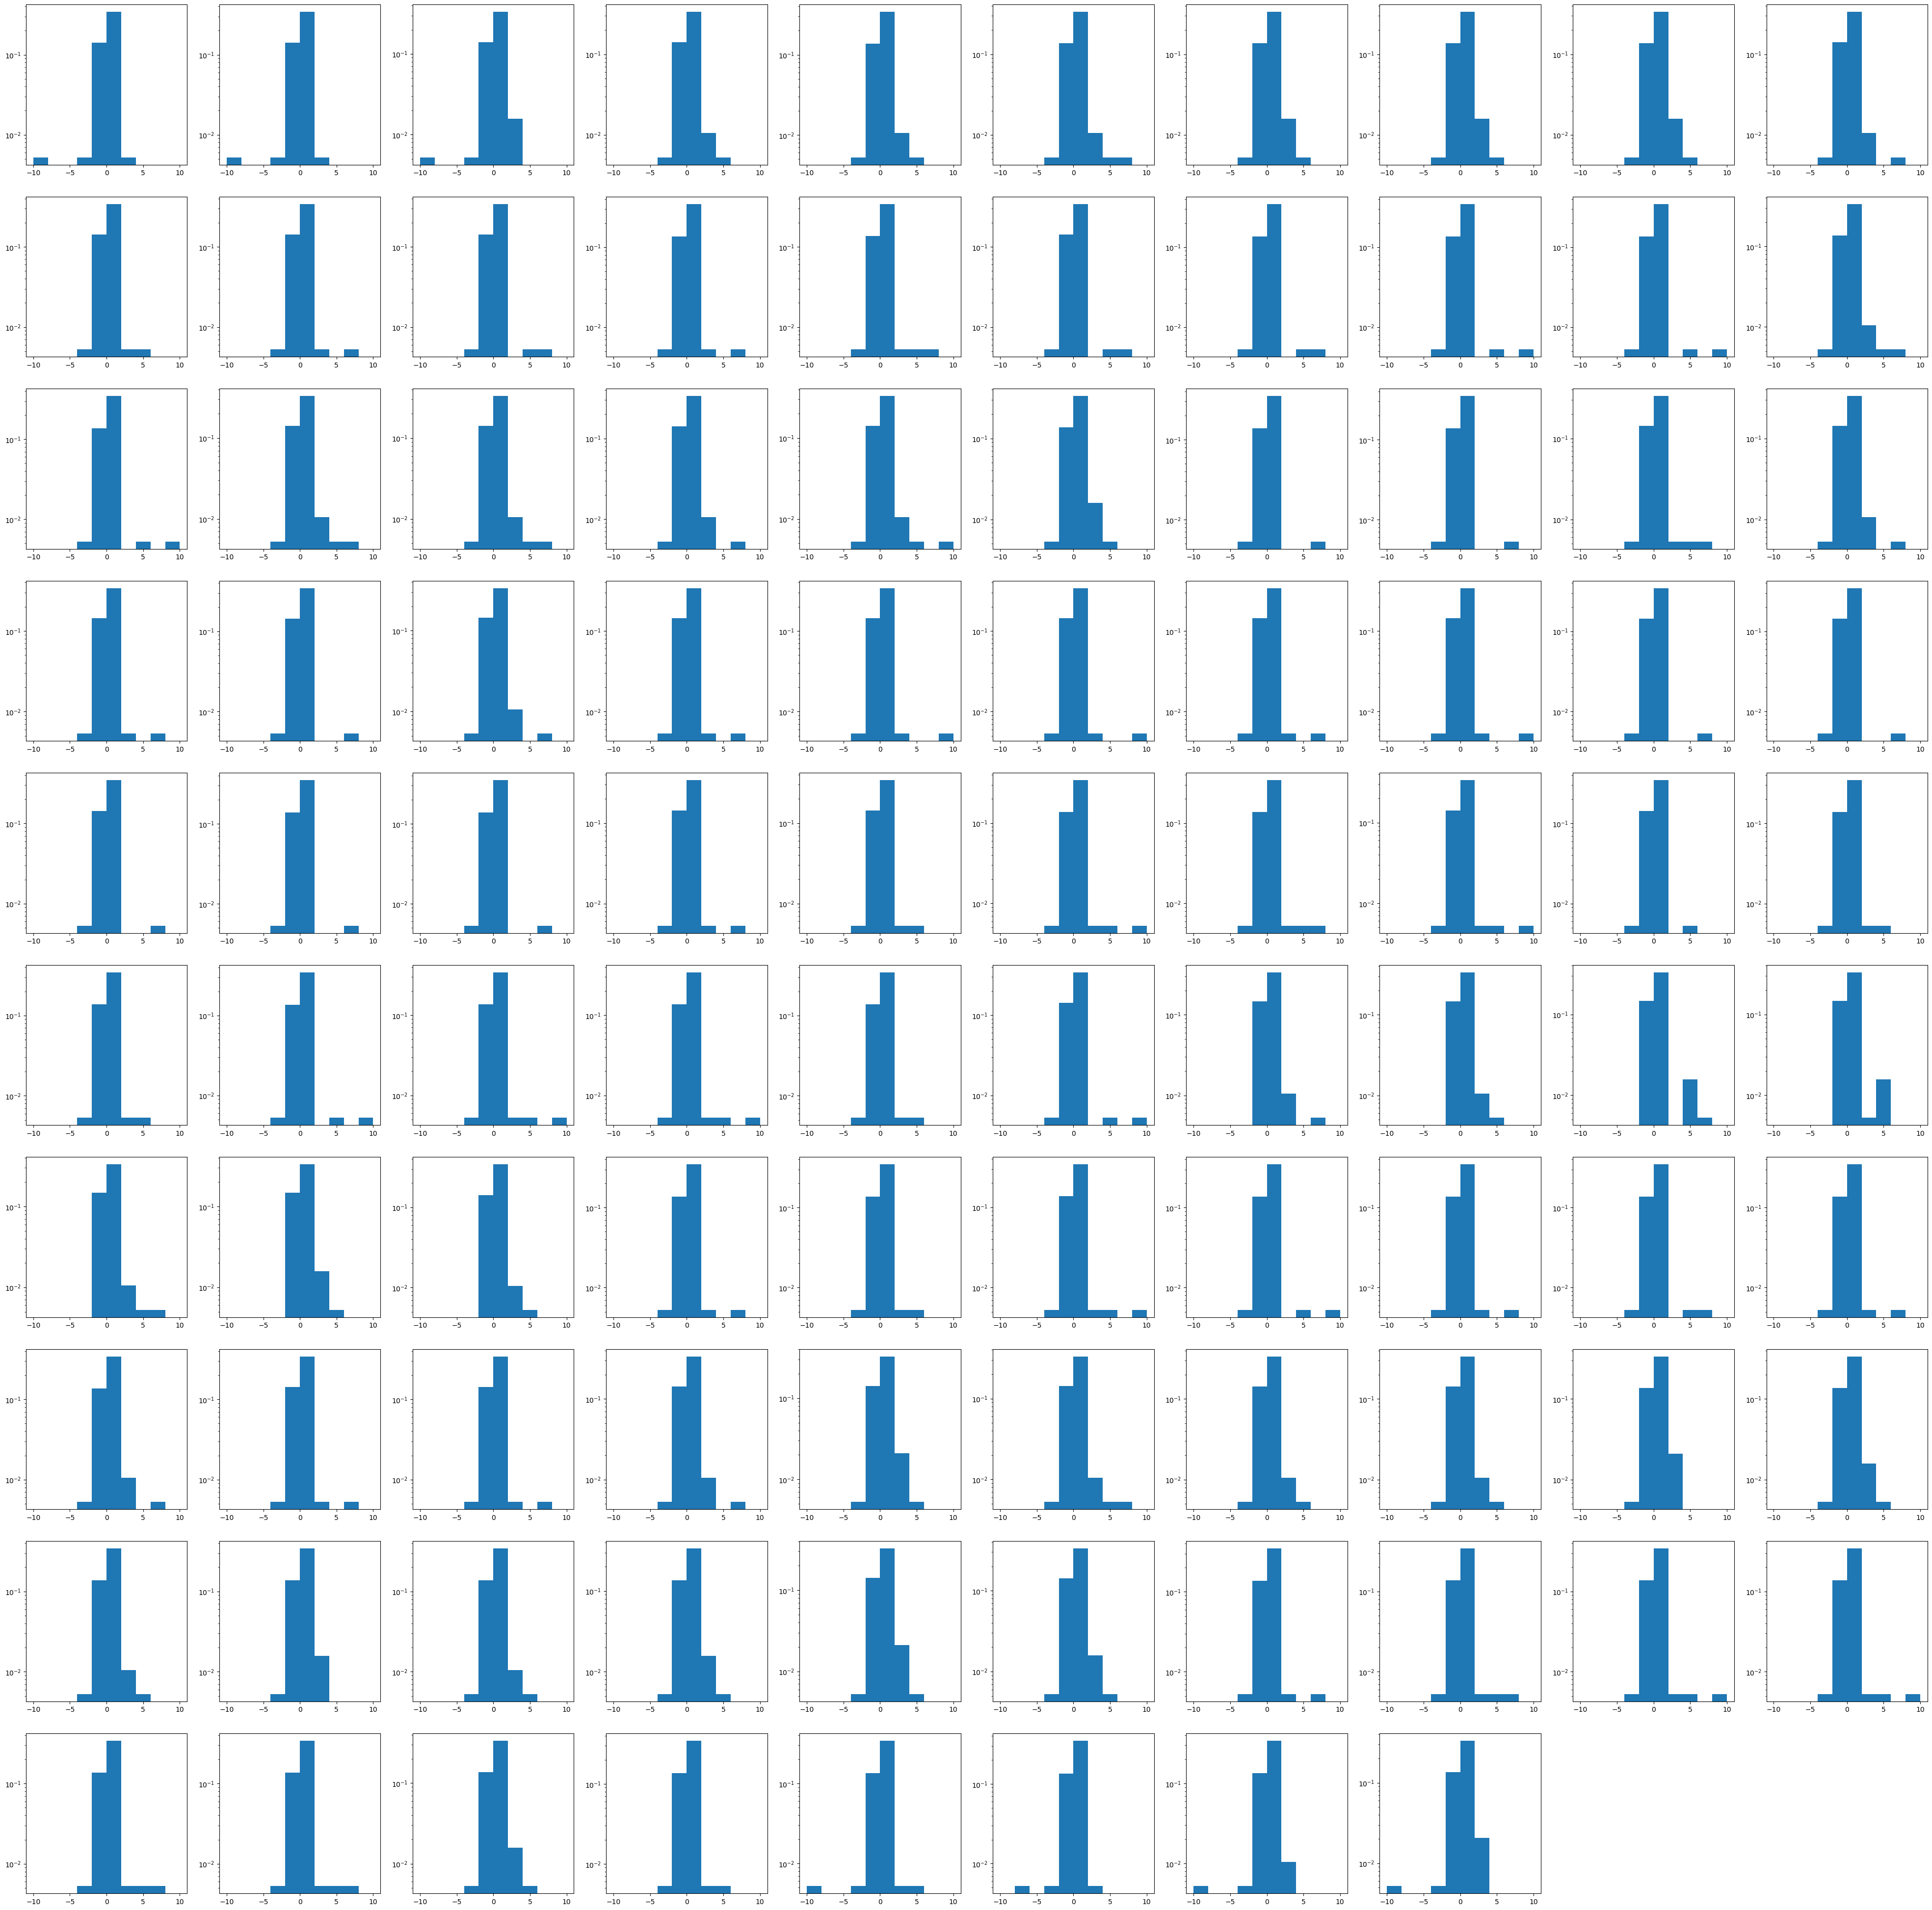

In [ ]:
num_plots = len(flux_samp_L_gasseri_filt)
cols = 10  # Number of columns in the grid
rows = (num_plots + cols - 1) // cols  # Calculate number of rows needed

fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5), constrained_layout=False)

# Flatten the axes array for easy iteration
axes = axes.flatten()

for i in range(0,len(flux_samp_L_gasseri_filt)):

        # Scatter plot on the respective subplot

    axes[i].hist(flux_samp_L_gasseri_filt.iloc[:,i], bins = 10, density=True, log = True, range=(-10,10))
    #axes[i].set_title(f"{met}")
    #axes[i].set_xlabel('Time')
    #axes[i].set_ylabel('Conc')
    #axes[i].set_yscale('log')
    #axes[i].legend_.remove()

# Hide any empty subplots if the number of plots is not a perfect square
for j in range(num_plots, len(axes)):
    fig.delaxes(axes[j])


#plot_file_name = plot_dir_path + '/Subject_' + str(subject_to_plot) + '_mets_exp_vs_sim_individual_scatterplots_' + str(test_num) + '.pdf'
#plt.savefig(plot_file_name, bbox_inches="tight")

In [80]:
loaded_models['Bacteroides_caecimuris'].optimize()

,fluxes,reduced_costs
EX_cpd02701_b,0.0,0.0
EX_cpd15302_b,0.0,0.0
EX_cpd11416_b,0.0,0.0
EX_cpd00067_b,0.0,0.0
EX_cpd00182_b,0.0,0.0
...,...,...
EX_cpd00149_e0,0.0,0.0
EX_cpd00063_e0,0.0,0.0
EX_cpd00254_e0,0.0,0.0
EX_cpd00027_e0,0.0,0.0


In [86]:
loaded_models['Duncaniealla_sp'].optimize()

,fluxes,reduced_costs
EX_cpd08636_b,0.000000,0.0
EX_cpd02701_b,0.000000,0.0
EX_cpd15302_b,0.000000,-0.0
EX_cpd11416_b,0.000000,0.0
EX_cpd00067_b,0.282667,0.0
...,...,...
EX_cpd00156_e0,0.000000,-0.0
EX_cpd00051_e0,0.000000,0.0
EX_cpd00066_e0,0.000000,-0.0
EX_cpd00644_e0,0.000000,-0.0


In [82]:
loaded_models['Merdibacter_massiliensis'].optimize()

,fluxes,reduced_costs
EX_cpd08636_b,0.000000,0.0
EX_cpd15302_b,0.000000,0.0
EX_cpd11416_b,22.340203,0.0
EX_cpd02701_b,0.000000,0.0
EX_cpd11576_b,0.000000,0.0
...,...,...
EX_cpd00066_e0,0.000000,0.0
EX_cpd00644_e0,0.000000,0.0
EX_cpd15378_e0,0.000000,0.0
EX_cpd02701_c0,0.000000,0.0


In [85]:
ex_b_reactions = [rxn for rxn in loaded_models['Merdibacter_massiliensis'].reactions if rxn.id.startswith('EX_') and rxn.id.endswith('_b')]

#print(f"Found {len(ex_b_reactions)} EX_*_b reactions:")

# Set all lower bounds to 0, with exceptions from diet data
for rxn in ex_b_reactions:
    if rxn.id in rc_diet_MS_convert['reaction'].to_list():  # Compare reaction ID, not object
        #print('yes - found in diet')
        # Fix the loc indexing - need to find the row where reaction matches
        #flux_value = temp_media[rxn.id]
        #rxn.lower_bound = -100.0#-1.0*flux_value
        rxn.lower_bound = -1.0*rc_diet_MS_convert[rc_diet_MS_convert['reaction'] == rxn.id]['fluxValue'].iloc[0]
        #print(f"Setting {rxn.id} lower bound to {rxn.lower_bound}")
    else:
        #print(f"Setting {rxn.id} lower bound from {rxn.lower_bound} to 0")
        rxn.lower_bound = 0
        ### here close the upper bound of the non-existent reactions too 
        #rxn.upper_bound = 0
loaded_models['Merdibacter_massiliensis'].optimize()        

,fluxes,reduced_costs
EX_cpd08636_b,0.000000,-0.075797
EX_cpd15302_b,0.000000,-0.000000
EX_cpd11416_b,0.113730,0.000000
EX_cpd02701_b,0.000000,-0.000000
EX_cpd11576_b,0.000000,-0.000000
...,...,...
EX_cpd00066_e0,0.000000,-0.000000
EX_cpd00644_e0,0.000000,-0.000000
EX_cpd15378_e0,0.000757,0.000000
EX_cpd02701_c0,0.000000,-0.000000


In [92]:
dunc_sol = models_for_FBA['391821255f31ef94686927f4fba6fbc3'].optimize()

In [97]:
dunc_sol

,fluxes,reduced_costs
EX_cpd08636_b,0.000000,0.0
EX_cpd02701_b,0.000000,0.0
EX_cpd15302_b,0.000000,0.0
EX_cpd11416_b,53.342172,0.0
EX_cpd00067_b,-256.980374,0.0
...,...,...
EX_cpd00156_e0,-16.158960,0.0
EX_cpd00051_e0,-10.865612,0.0
EX_cpd00066_e0,0.000000,0.0
EX_cpd00644_e0,-0.709780,0.0


In [100]:
rc_diet_MS_convert['reaction'].sort_values().to_list()

['EX_cpd00001_b',
 'EX_cpd00009_b',
 'EX_cpd00013_b',
 'EX_cpd00020_b',
 'EX_cpd00023_b',
 'EX_cpd00027_b',
 'EX_cpd00028_b',
 'EX_cpd00030_b',
 'EX_cpd00033_b',
 'EX_cpd00034_b',
 'EX_cpd00035_b',
 'EX_cpd00036_b',
 'EX_cpd00041_b',
 'EX_cpd00048_b',
 'EX_cpd00058_b',
 'EX_cpd00060_b',
 'EX_cpd00063_b',
 'EX_cpd00066_b',
 'EX_cpd00067_b',
 'EX_cpd00069_b',
 'EX_cpd00076_b',
 'EX_cpd00082_b',
 'EX_cpd00084_b',
 'EX_cpd00099_b',
 'EX_cpd00106_b',
 'EX_cpd00107_b',
 'EX_cpd00108_b',
 'EX_cpd00121_b',
 'EX_cpd00129_b',
 'EX_cpd00130_b',
 'EX_cpd00137_b',
 'EX_cpd00149_b',
 'EX_cpd00156_b',
 'EX_cpd00161_b',
 'EX_cpd00205_b',
 'EX_cpd00214_b',
 'EX_cpd00218_b',
 'EX_cpd00224_b',
 'EX_cpd00244_b',
 'EX_cpd00254_b',
 'EX_cpd00322_b',
 'EX_cpd00382_b',
 'EX_cpd00392_b',
 'EX_cpd00396_b',
 'EX_cpd00536_b',
 'EX_cpd00550_b',
 'EX_cpd00597_b',
 'EX_cpd00851_b',
 'EX_cpd00971_b',
 'EX_cpd01055_b',
 'EX_cpd01107_b',
 'EX_cpd01113_b',
 'EX_cpd01122_b',
 'EX_cpd01293_b',
 'EX_cpd01741_b',
 'EX_cpd02

In [96]:
models_for_FBA['391821255f31ef94686927f4fba6fbc3'].summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
cpd00007_b,EX_cpd00007_b,723.2,0,0.00%
cpd00013_b,EX_cpd00013_b,46.14,0,0.00%
cpd00027_b,EX_cpd00027_b,65.47,0,0.00%
cpd00028_b,EX_cpd00028_b,0.3549,0,0.00%
cpd00029_b,EX_cpd00029_b,93.1,0,0.00%
cpd00030_b,EX_cpd00030_b,0.3549,0,0.00%
cpd00034_b,EX_cpd00034_b,0.3549,0,0.00%
cpd00048_b,EX_cpd00048_b,0.3549,0,0.00%
cpd00051_b,EX_cpd00051_b,10.87,0,0.00%
cpd00058_b,EX_cpd00058_b,0.3549,0,0.00%
